In [ ]:
import os
from google.colab import drive

# mounting to drive
drive.mount("/content/drive")
os.chdir("drive/MyDrive")

Mounted at /content/drive


#Preprocessing
##Load embeddings

In [ ]:
import pickle
import numpy as np

# deserialize word embeddings biased and debiased and the tokenizer word-token dictionary

f = open("word_embedding_debiased", "rb")
emb_aft = pickle.load(f).numpy()
f.close()

f = open("word_embedding_biased", "rb")
emb_bef = pickle.load(f).numpy()
f.close()

f = open("token_dictionary", "rb")
full_word_index = pickle.load(f)
f.close()

keys = list(full_word_index.keys())[:10000] 
word_index = {key: full_word_index[key] for key in keys}


# list of all words in vocabulary 
vocab = list(word_index.keys())

def normalize(wv):
    """Normalize word vectors."""
    norms = np.apply_along_axis(np.linalg.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

wv = {}
wv['bef'] = normalize(emb_bef)
wv['aft'] = normalize(emb_aft)
w2i = {'bef': word_index, 'aft': word_index}
vocab = {'bef': vocab, 'aft': vocab}
print(wv['bef'].shape)


(10001, 400)


In [ ]:
def topK(w, space, k=10):
    """Get top k most similar words in for a word w.

    Returns:
        list of words (str)"""

    # extract the word vector for word w
    idx = w2i[space][w] -1
    vec = wv[space][idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]


def similarity(w1, w2, space): # necessary??
    
    i1 = w2i[space][w1] -1
    i2 = w2i[space][w2] -1
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)

##Restrict vocabulary

In [ ]:
def limit_vocab(space, exclude):
    """Removes list of words to be excluded from wv, w2i and vocab."""
    # remove exclude from vocab
    vocab_limited = list(set(vocab[space]) - set(exclude))

    # remove exclude from embedding
    wv_limited = np.zeros((len(vocab_limited), 400))
    for i, w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w]-1,:]
    
    # remove exclude from w2i dict
    w2i_limited = {w: i+1 for i, w in enumerate(vocab_limited)}

    return vocab_limited, wv_limited, w2i_limited

In [ ]:
import codecs
import json

# load gender lists
with codecs.open('gender_specific_full.json') as f:
    gender_specific = json.load(f)
with codecs.open('definitional_pairs.json') as f:
    definitional_pairs = json.load(f)
with codecs.open('equalize_pairs.json') as f:
    equalize_pairs = json.load(f)

# make exclude list of gender specific words
exclude_words = []
for pair in definitional_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])
exclude_words = list(set(exclude_words).union(set(gender_specific)))


# create the reduced vocabularies and embeddings before and after, without gendered specific words
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words)


##Compute bias-by-projection

In [ ]:
def compute_bias_by_projection(space_to_tag, full_space):
    """Create a dictionary of the bias-by-projection for each word in the vocabulary."""
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he']-1,:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she']-1,:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d

# compute bias-by-projection before and after debiasing
gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')

In [ ]:
def report_bias(gender_bias):
    """Calculates the average bias of a word-bias dictionary"""
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))

# calculate the avg bias of the vocabulary (abs) before and after debiasin
report_bias(gender_bias_bef)
report_bias(gender_bias_aft)

0.05773587987196934
0.055245956613002606


In [ ]:
print(wv['limit_bef'].shape)
print(len(vocab['limit_bef']))
print(len(w2i['limit_bef']))

(9910, 400)
9910
9910


#Experiments
##Correlation between bias-by-projection and bias-by-neighbors

In [ ]:
def bias_by_neighbors(space, neighbours_num = 100):
    """Get tuples of biases and counts of masculine/feminine nearest neighbors 
    for each word (for bias-by-neighbors).
    Returns:
        list of tuples containing 
            - word of vocab,
            - its bias-by-projection before debiasing,
            - its bias-by-projection after debiasing,
            - counts of male nearest neighbor words, and
            - counts of male nearest neighbor words.
    """
    
    tuples = []
    for w in vocab[space]:
        
        top = topK(w, space, k=neighbours_num+5)[:neighbours_num]

        m = 0
        f = 0    
        for t in top:
            if gender_bias_bef[t] > 0:
                m+=1
            else:
                f+=1
            
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))

    return tuples

# get tuples of biases and counts of masculine/feminine NN
tuples_bef = bias_by_neighbors('limit_bef') 
tuples_aft = bias_by_neighbors('limit_aft')       

In [ ]:
import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    """Compute pearson correlation between elements at index i1 and i2 
    of passed tuples."""
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    print(pearson(a,b))

# compute correlation between bias-by-projection and bias-by-neighbors (specifically male counts of NN)
compute_corr(tuples_bef, 1, 3) 
compute_corr(tuples_aft, 1, 3)

PearsonRResult(statistic=0.7254033676402126, pvalue=0.0)
PearsonRResult(statistic=-0.012589765275578509, pvalue=0.21013660651196608)


##Clustering Experiment - Visualize clusters of most biased words

In [ ]:
!pip install mpld3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 9.0 MB/s eta 0:00:00


In [ ]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3
from cycler import cycler
%matplotlib inline
mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    
def extract_vectors(words, space1 = 'limit_bef', space2 = 'limit_aft'):
    
    size = len(words)/2
    
    X_bef = [wv[space1][w2i[space1][x]-1,:] for x in words]
    X_aft = [wv[space2][w2i[space2][x]-1,:] for x in words]

    return np.array(X_bef), np.array(X_aft)


def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    fig.show()
    

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


precision bef 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


precision aft 0.496


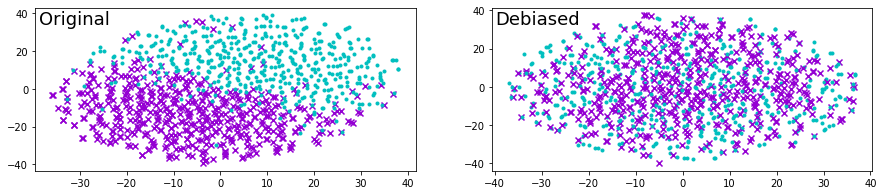

In [ ]:
# Cluster most biased words before and after debiasing
import operator

random_state = 1

size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

X_bef, X_aft = extract_vectors(male + female)
y_true = [1]*size + [0]*size
cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)

##Professions in experiment

In [ ]:
def extract_professions():
    professions = []
    with codecs.open('professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()

In [ ]:
import scipy.stats

def get_tuples_prof(space, words, gender_bias_dict):

    tuples = []
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        top = topK(w, space, k=105)[:100]
            
        m = 0
        f = 0  
        for t in top:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))
        
    return tuples


tuples_bef_prof = get_tuples_prof('limit_bef', professions, gender_bias_bef)
tuples_aft_prof = get_tuples_prof('limit_aft', professions, gender_bias_bef)

compute_corr(tuples_bef_prof, 1, 3)
compute_corr(tuples_aft_prof, 1, 3)

PearsonRResult(statistic=0.7888980585608044, pvalue=3.212154324767702e-25)
PearsonRResult(statistic=0.1805472126407788, pvalue=0.05566343130054507)


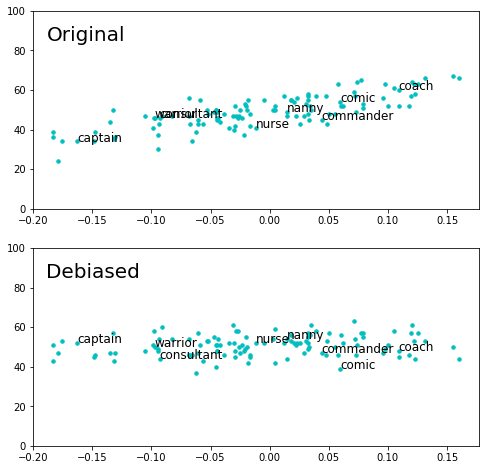

In [ ]:
# Show plots

def show_plots(tuples_bef_prof, tuples_aft_prof):
    
    fig, axs = plt.subplots(2,1, figsize=(8,8))
    
    for i,(tuples, title) in enumerate(zip([tuples_bef_prof, tuples_aft_prof], ['Original', 'Debiased'])):
        X = []
        Y = []
        for t in tuples:
            X.append(t[1])
            Y.append(t[3])

        axs[i].scatter(X,Y, color = 'c', s=12)
        axs[i].set_ylim(0,100)
        
        for t in tuples:
            if t[0] in ['nanny', 'librarian', 'hairdresser', 'receptionist', 'nurse',\
                       'consultant', 'warden', 'archaeologist', 'banker', 'comic',\
                        'warrior', 'skipper', 'captain', 'commander', 'coach']:
                axs[i].annotate(t[0], xy=(t[1], t[3]), xytext=(t[1], t[3]), textcoords="data", fontsize=12) 
        axs[i].text(.03, .85, title, transform=axs[i].transAxes, fontsize=20)
    
    
    fig.show()
    

show_plots(tuples_bef_prof, tuples_aft_prof)



##Classification experiment

In [ ]:
# take 5000 most biased words, split each polarity randomly to train (1/5) and test (4/5), and predict

from sklearn import svm
from random import shuffle
import random
random.seed(10)



def train_and_predict(space_train, space_test):
    
    X_train = [wv[space_train][w2i[space_train][w]-1,:] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [wv[space_test][w2i[space_test][w]-1,:] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    print('train with', space_train)
    print('test with', space_test)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    print('accuracy:', float(sum(accuracy))/len(accuracy))

    
# extract nost biased words

size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(gender_bias_bef[f] < 0)
for m in males:
    assert(gender_bias_bef[m] > 0)
shuffle(females)
shuffle(males)

# classification before debiasing

train_and_predict('bef', 'bef')

# classification after debiasing

train_and_predict('aft', 'aft')

train with bef
test with bef
accuracy: 0.9915
train with aft
test with aft
accuracy: 0.49925
